# Infer CNV on lung cancer dataset

In [2]:
import scanpy as sc
import infercnvpy as cnv
import matplotlib.pyplot as plt
import anndata as ad

sc.settings.set_figure_params(figsize=(5, 5))

In [3]:
sc.logging.print_header()

/Users/carmen.robinson/miniconda3/envs/cnv/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/carmen.robinson/miniconda3/envs/cnv/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/carmen.robinson/miniconda3/envs/cnv/lib/python3

scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.24.3 scipy==1.10.1 pandas==2.0.1 scikit-learn==1.2.2 statsmodels==0.14.0rc0 python-igraph==0.10.4 pynndescent==0.5.10


/Users/carmen.robinson/miniconda3/envs/cnv/lib/python3.11/site-packages/umap/umap_.py:660: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()


## Loading the example dataset

In [4]:
#adata = cnv.datasets.maynard2020_3k()
adata = ad.read("adata_snRNAseq2")

In [20]:
set(adata.obs["Age"])

{'3 months'}

In [6]:
sc.pp.log1p(adata)

In [7]:
adata.var['chromosome'] = adata.var['chromosome'].apply(lambda x: 'chr' + str(x) if str(x).isnumeric() else x)

In [8]:
adata.var['chromosome'] = adata.var['chromosome'].apply(lambda x: 'chr' + str(x) if len(x)<2 else x)

/Users/carmen.robinson/miniconda3/envs/cnv/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


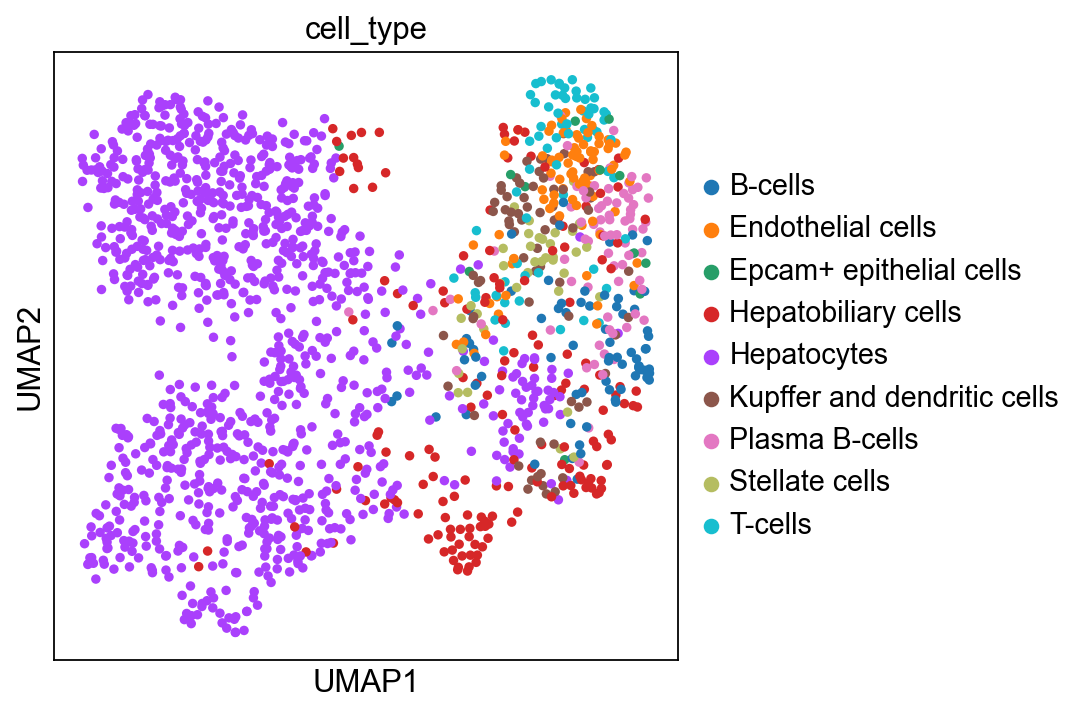

In [9]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata
           , color="cell_type")

In [10]:
type(adata.var)

pandas.core.frame.DataFrame

Let's first inspect the UMAP plot based on the transcriptomics data:

## Removing cells that are not hepatocytes

In [11]:
adata = adata[adata.obs["cell_type"]== "Hepatocytes", :]

In [12]:
adata. obs["cell_type"]

do20283           Hepatocytes
do20284           Hepatocytes
do20285           Hepatocytes
do20287           Hepatocytes
do20290           Hepatocytes
                     ...     
ID-SNI-626-7-G    Hepatocytes
ID-SNI-626-8-F    Hepatocytes
ID-SNI-626-8-G    Hepatocytes
ID-SNI-626-9-E    Hepatocytes
ID-SNI-626-9-G    Hepatocytes
Name: cell_type, Length: 1061, dtype: category
Categories (1, object): ['Hepatocytes']

## Running infercnv

In [19]:
# They provide all immune cell types as "normal cells".
cnv.tl.infercnv(
    adata,
     #reference_key="Ploidy",
    #reference_cat=["2n"],
    window_size=250,
)

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.08s/it]


Now, we can plot smoothed gene expression by cell-type and chromosome. 
We can observe that the Epithelial cell cluster, which consists largely of tumor cells, appears
to be subject to copy number variation. 

cnv.pl.chromosome_heatmap(adata, groupby="cell_type")

## Clustering by CNV profiles and identifying tumor cells

In [20]:
cnv.tl.pca(adata)
cnv.pp.neighbors(adata)
cnv.tl.leiden(adata)

After running leiden clustering, we can plot the chromosome heatmap 
by CNV clusters. We can observe that, as opposted to the clusters 
at the bottom, the clusters at the top have essentially no differentially expressed genomic regions. 
The differentially expressed regions are likely due to copy number variation and the respective 
clusters likely represent tumor cells. 

In [1]:
cnv.pl.chromosome_heatmap(adata, groupby="Ploidy", dendrogram=True)

NameError: name 'cnv' is not defined

### UMAP plot of CNV profiles

In [22]:
cnv.tl.umap(adata)
cnv.tl.cnv_score(adata)

The UMAP plot consists of a large blob of "normal" cells and several smaller clusters
with distinct CNV profiles. Except for cluster "12", which consists of ciliated cells, 
the isolated clusters are all epithelial cells. These are likely tumor cells and each 
cluster represents an individual sub-clone.

/Users/carmenrobinson/miniconda3/envs/singlecell/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/carmenrobinson/miniconda3/envs/singlecell/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'Ploidy'}, xlabel='cnv_umap1', ylabel='cnv_umap2'>

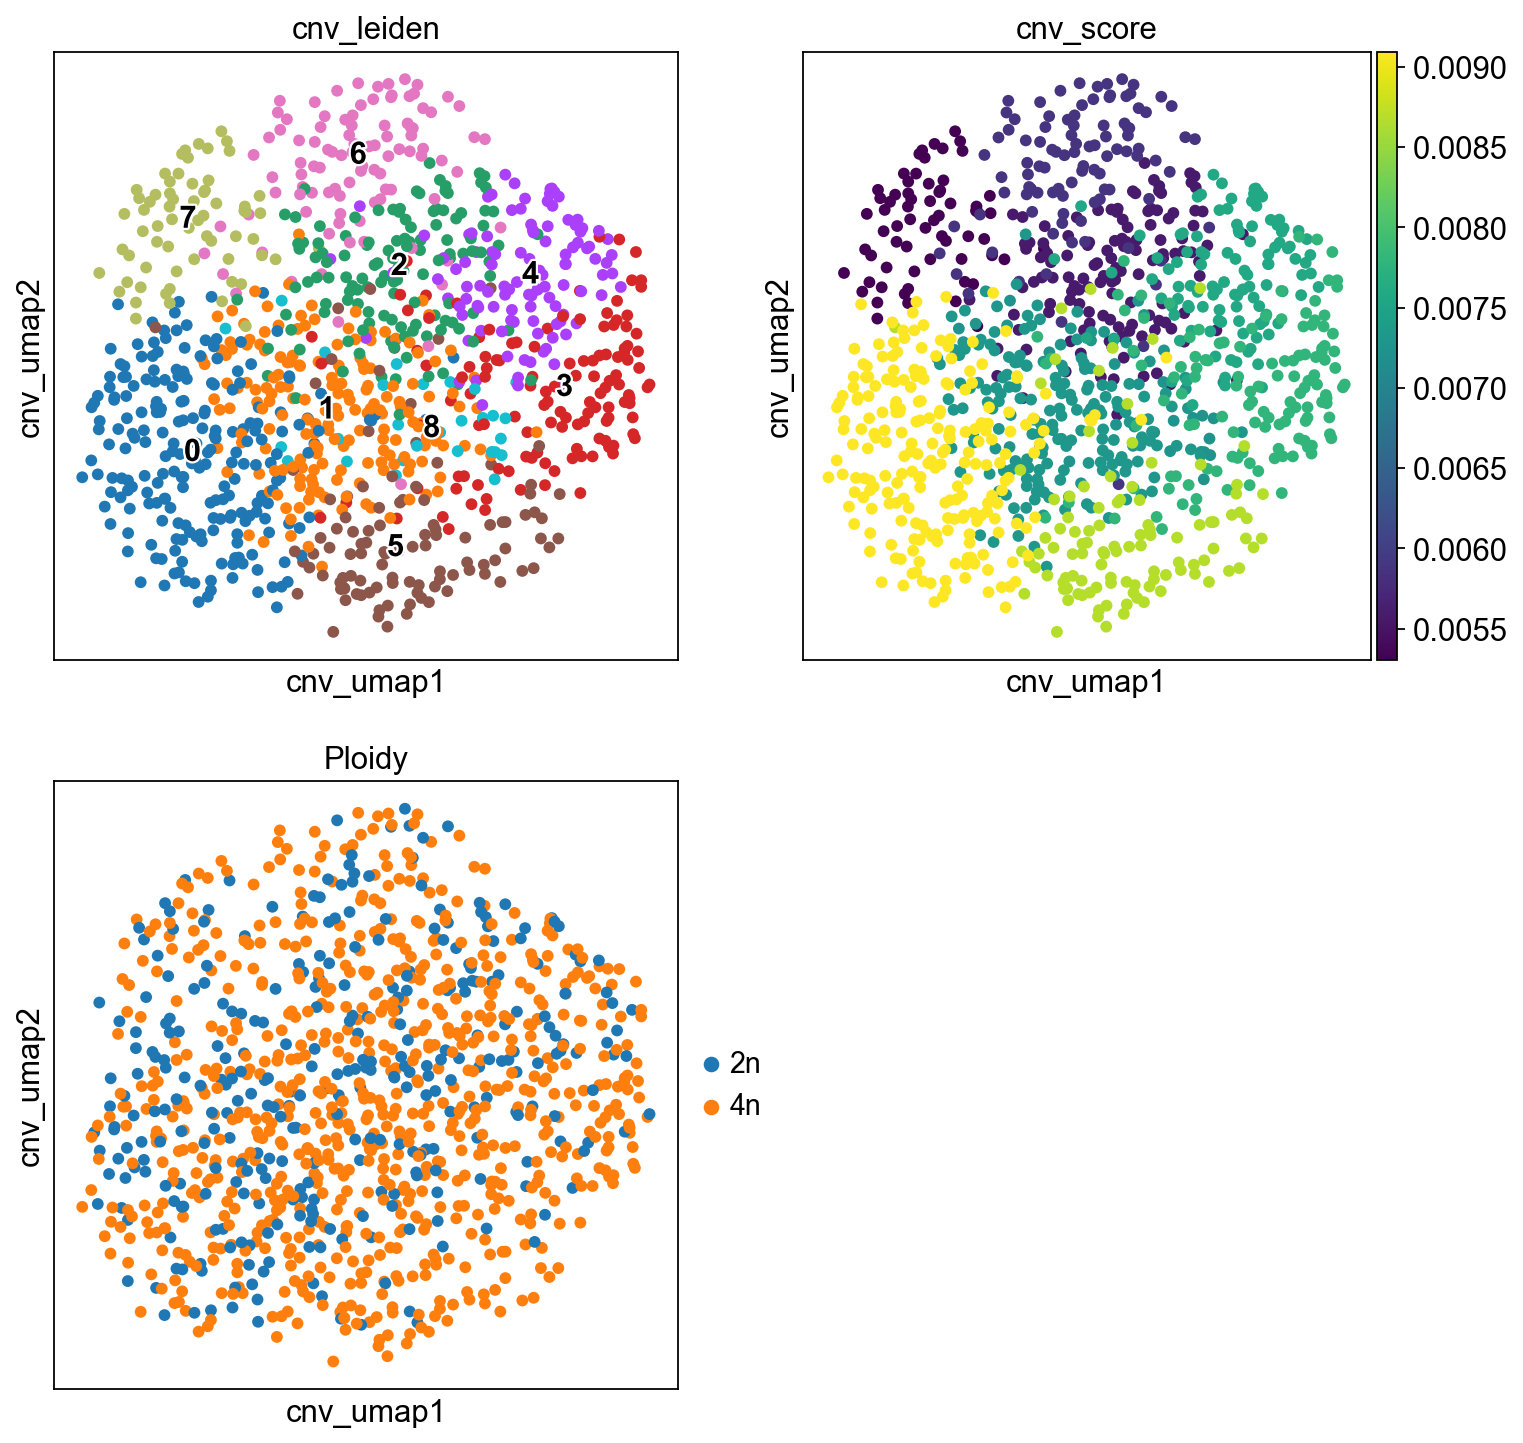

In [23]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(11, 11))
ax4.axis("off")
cnv.pl.umap(
    adata,
    color="cnv_leiden",
    legend_loc="on data",
    legend_fontoutline=2,
    ax=ax1,
    show=False,
)
cnv.pl.umap(adata, color="cnv_score", ax=ax2, show=False)
cnv.pl.umap(adata, color="Ploidy", ax=ax3, show=False)

We can also visualize the CNV score and clusters on the transcriptomics-based UMAP plot. 
Again, we can see that there are subclusters of epithelial cells that belong
to a distinct CNV cluster, and that these clusters tend to have the 
highest CNV score. 

/Users/carmenrobinson/miniconda3/envs/singlecell/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/carmenrobinson/miniconda3/envs/singlecell/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


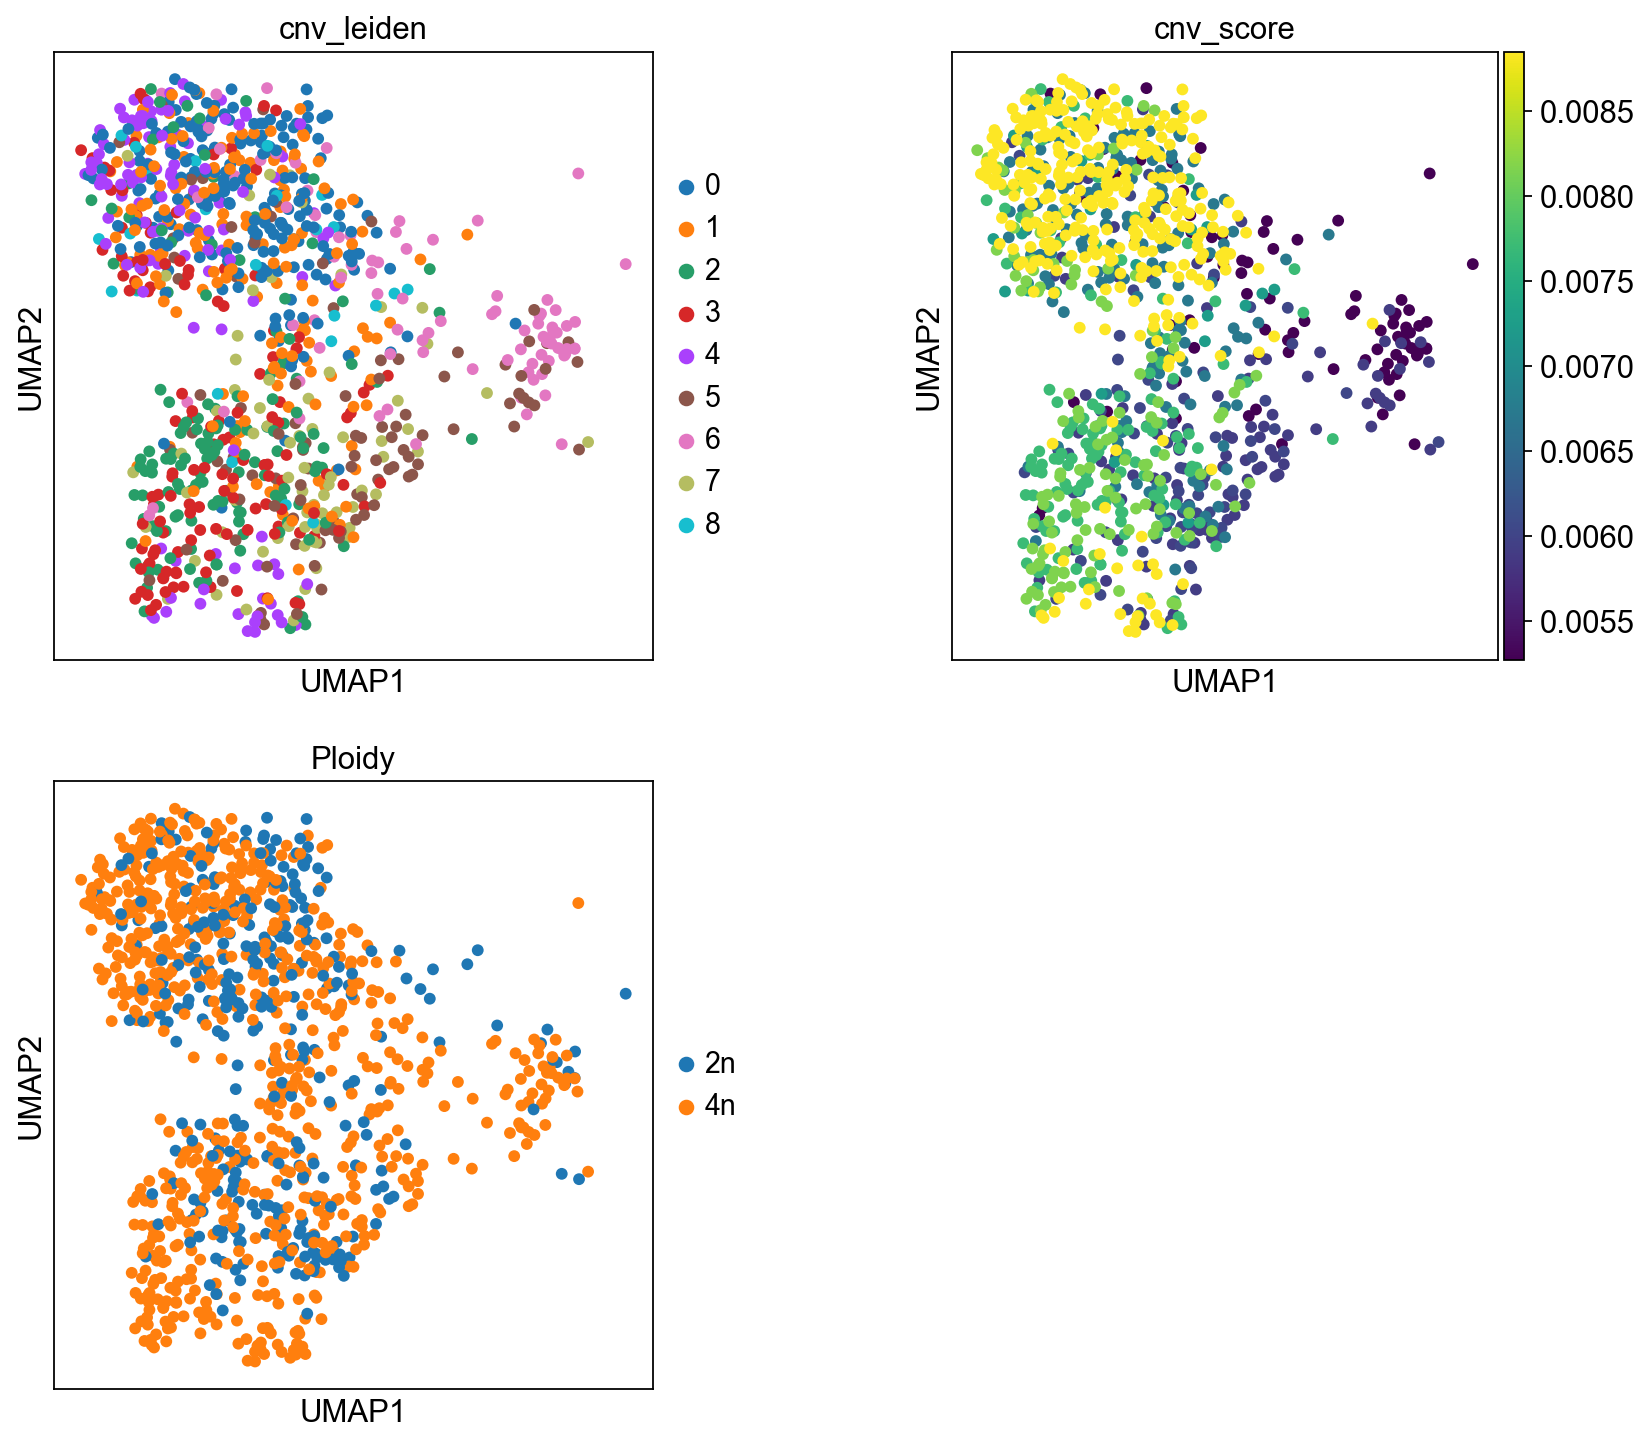

In [17]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
    2, 2, figsize=(12, 11), gridspec_kw=dict(wspace=0.5)
)
ax4.axis("off")
sc.pl.umap(adata, color="cnv_leiden", ax=ax1, show=False)
sc.pl.umap(adata, color="cnv_score", ax=ax2, show=False)
sc.pl.umap(adata, color="Ploidy", ax=ax3)

### Classifying tumor cells

Based on these observations, we can now assign cell to either "tumor" or "normal". 
To this end, we add a new column `cnv_status` to `adata.obs`. 

In [ ]:
adata.obs["cnv_status"] = "normal"
adata.obs.loc[
    adata.obs["Ploidy"]== "4n", "cnv_status"
] = 'altered'
#"tumor"

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw=dict(wspace=0.5))
cnv.pl.umap(adata, color="cnv_status", ax=ax1, show=False)
sc.pl.umap(adata, color="cnv_status", ax=ax2)

Now, we can plot the CNV heatmap for tumor and normal cells separately: 

In [ ]:
cnv.pl.chromosome_heatmap(adata[adata.obs["cnv_status"] == "altered", :])

In [ ]:
cnv.pl.chromosome_heatmap(adata[adata.obs["cnv_status"] == "normal", :])